In [2]:
import os

import numpy as np
import pandas as pd 
from nilearn.plotting import plot_stat_map
import json
import csv
import nimare
from nimare.correct import FWECorrector
from ale import ALESubtraction
from nimare.results import MetaResult
from nimare.transforms import tal2mni
from nilearn.plotting import plot_stat_map
#from nimare.tests.utils import get_test_data_path

### import emotion dataset

In [3]:
emotion_dset = pd.read_csv('meta061106.csv')
emotion_dset.keys()

Index(['Study', 'headstable', 'Scan', 'ROI', 'CoordSys', 'Subjects', 'Women',
       'Gender', 'Mode', 'FixedRandom', 'Stimuli', 'Method_', 'Emotion',
       'Valence', 'EERMean', 'EERSD', 'EERRS', 'Subtraction', 'Contrast',
       'Target', 'Ref', 'Other', 'Intrascan_cog', 'x', 'y', 'z', 'zscore',
       'tscore', 'p_threshold', 'pcorrection', 'Region', 'Notes',
       'SubjectiveWeights', 'Affect_focus', 'Cog_load', 'object_eval',
       'feel_arousal', 'phys_arous'],
      dtype='object')

In [4]:
emotion_dset

,Study,headstable,Scan,ROI,CoordSys,Subjects,Women,Gender,Mode,FixedRandom,...,p_threshold,pcorrection,Region,Notes,SubjectiveWeights,Affect_focus,Cog_load,object_eval,feel_arousal,phys_arous
0,Aalto2002,no,PET,no,SPM99,11,11.0,f,exp,rand,...,0.01,corrected,L_superior_temporal_gyrus,NaN,1.0,NaN,no,NaN,neutral,n
1,Aalto2002,no,PET,no,SPM99,11,11.0,f,exp,rand,...,0.01,corrected,L_superior_temporal_gyrus,NaN,1.0,NaN,no,NaN,neutral,n
2,Aalto2002,no,PET,no,SPM99,11,11.0,f,exp,rand,...,0.01,corrected,L_inferior_temporal_gyrus,NaN,1.0,NaN,no,NaN,neutral,n
3,Aalto2002,no,PET,no,SPM99,11,11.0,f,exp,rand,...,0.01,corrected,L_superior_temporal_gyrus,NaN,1.0,NaN,no,NaN,neutral,n
4,Aalto2002,no,PET,no,SPM99,11,11.0,f,exp,rand,...,0.01,corrected,R_middle_temporal_gyrus,NaN,1.0,NaN,no,NaN,neutral,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,Gur2002,no,fMRI,no,MNI,14,7.0,b,per,rand,...,0.05,corrected,R_Thalamus,NaN,1.0,foreground,yes,stimulus,NaN,n
2474,Gur2002,no,fMRI,no,MNI,14,7.0,b,per,rand,...,0.05,corrected,L_Inferior_frontal,NaN,1.0,foreground,yes,stimulus,NaN,n
2475,Gur2002,no,fMRI,no,MNI,14,7.0,b,per,rand,...,0.05,corrected,R_Inferior_frontal,NaN,1.0,foreground,yes,stimulus,NaN,n
2476,Gur2002,no,fMRI,no,MNI,14,7.0,b,per,rand,...,0.05,corrected,L_occipital,NaN,1.0,foreground,yes,stimulus,NaN,n


In [5]:
emotion_list = list(emotion_dset.loc[:,'Emotion'])
unique_emotion_list = list(set(emotion_list))
print('There are 8 types of emotions:', unique_emotion_list)

There are 8 types of emotions: ['mixed', 'aff', 'happy', 'sad', 'fear', 'disgust', 'surprise', 'anger']


### rearrange studies by emotion

In [28]:
emotion_category = dict() # use 8 types of emotions as keys
for emotion in unique_emotion_list:
    columns = emotion_dset.loc[emotion_dset['Emotion'] == emotion]
    foci = list(columns.loc[:,'Study'])
    study = list(set(foci))
    emotion_category[emotion] = study
#print(emotion_category)

In [10]:
emotion_data = {}

with open('meta061106.csv') as csvFile:
    csvReader = csv.DictReader(csvFile)
    prev_study_id = ''
    for rows in csvReader:
        emotion = rows['Emotion']
        study_id = rows['Study']
        contrast = rows['Contrast']
        coordinate_system = 'MNI'#rows['CoordSys']
        sample_size = int(rows['Subjects'])
        
        #transform into MNI space
        xyz_coord = np.array([float(rows['x']), float(rows['y']), float(rows['z'])]).reshape((1,3))
        xyz_coord = tal2mni(xyz_coord)
        
        if study_id != prev_study_id:
            x_coord, y_coord, z_coord = [xyz_coord[0][0]], [xyz_coord[0][1]], [xyz_coord[0][2]]
            #[float(rows['x'])], [float(rows['y'])], [float(rows['z'])]
    
        else:
            x_coord.append(xyz_coord[0][0])
            y_coord.append(xyz_coord[0][1])
            z_coord.append(xyz_coord[0][2])
        prev_study_id = study_id
        coord = {'space':coordinate_system,'x':x_coord, 'y': y_coord, 'z': z_coord}
        
        meta_data = {'sample_sizes':[sample_size]}
        
        emotion_data[study_id] = {'contrasts':{contrast:{'coords':coord, 'metadata':meta_data}}}


In [25]:
def categorized_data(emotion_type):
    categorized_data = {}
    categorized_studies = emotion_category[emotion_type]

    with open('meta061106.csv') as csvFile:
        csvReader = csv.DictReader(csvFile)
        prev_study_id = ''
        for rows in csvReader:
            emotion = rows['Emotion']
            if emotion == emotion_type:
                study_id = rows['Study']
                contrast = rows['Contrast']
                coordinate_system = 'MNI'#rows['CoordSys']
                sample_size = int(rows['Subjects'])

                #transform into MNI space
                xyz_coord = np.array([float(rows['x']), float(rows['y']), float(rows['z'])]).reshape((1,3))
                xyz_coord = tal2mni(xyz_coord)

                if study_id != prev_study_id:
                    x_coord, y_coord, z_coord = [xyz_coord[0][0]], [xyz_coord[0][1]], [xyz_coord[0][2]]

                else:
                    x_coord.append(xyz_coord[0][0])
                    y_coord.append(xyz_coord[0][1])
                    z_coord.append(xyz_coord[0][2])
                prev_study_id = study_id
                coord = {'space':coordinate_system,'x':x_coord, 'y': y_coord, 'z': z_coord}
                meta_data = {'sample_sizes':[sample_size]}

                categorized_data[study_id] = {'contrasts':{contrast:{'coords':coord, 'metadata':meta_data}}}

    return categorized_data

In [29]:
mixed_data = categorized_data(emotion_type='mixed')
aff_data = categorized_data(emotion_type='aff')
happy_data = categorized_data(emotion_type='happy')
sad_data = categorized_data(emotion_type='sad')
fear_data = categorized_data(emotion_type='fear')
disgust_data = categorized_data(emotion_type='disgust')
surprise_data = categorized_data(emotion_type='surprise')
anger_data = categorized_data(emotion_type='anger')


In [56]:
# convert emotion_data from dictionary to nimare.dataset
emotion_dset = nimare.dataset.Dataset(emotion_data)

mask_img = emotion_dset.masker.mask_img
mask_array = np.array(mask_img.dataobj)
mask_array[mask_array>0] = 1

In [57]:
emotion_dset

In [30]:
mixed_dset = nimare.dataset.Dataset(mixed_data)
mask_img_mixed = mixed_dset.masker.mask_img

aff_dset = nimare.dataset.Dataset(aff_data)
mask_img_aff = aff_dset.masker.mask_img

happy_dset = nimare.dataset.Dataset(happy_data)
mask_img_happy = happy_dset.masker.mask_img

sad_dset = nimare.dataset.Dataset(sad_data)
mask_img_sad = sad_dset.masker.mask_img

fear_dset = nimare.dataset.Dataset(fear_data)
mask_img_fear = fear_dset.masker.mask_img

disgust_dset = nimare.dataset.Dataset(disgust_data)
mask_img_disgust = disgust_dset.masker.mask_img

surprise_dset = nimare.dataset.Dataset(surprise_data)
mask_img_surprise = surprise_dset.masker.mask_img

anger_dset = nimare.dataset.Dataset(anger_data)
mask_img_anger = anger_dset.masker.mask_img

In [31]:
mixed_ale = nimare.meta.cbma.ALE()
mixed_ale.fit(mixed_dset)

aff_ale = nimare.meta.cbma.ALE()
aff_ale.fit(aff_dset)

happy_ale = nimare.meta.cbma.ALE()
happy_ale.fit(happy_dset)

sad_ale = nimare.meta.cbma.ALE()
sad_ale.fit(sad_dset)

fear_ale = nimare.meta.cbma.ALE()
fear_ale.fit(fear_dset)

disgust_ale = nimare.meta.cbma.ALE()
disgust_ale.fit(disgust_dset)

surprise_ale = nimare.meta.cbma.ALE()
surprise_ale.fit(surprise_dset)

anger_ale = nimare.meta.cbma.ALE()
anger_ale.fit(anger_dset)

### ALE Subtraction analysis

In [169]:
from ale import ALESubtraction

ale_subtraction = ALESubtraction(n_iters=1000)
result = ale_subtraction.fit(sad_ale, sad_ale)
ale_subtraction2 = nimare.meta.cbma.ale.ALESubtraction(n_iters=1000)
result2 = ale_subtraction2.fit(sad_ale, sad_ale)

In [170]:
corrector = FWECorrector(method='bonferroni',n_iters=1000, voxel_thresh=0.001, n_cores=-1)
corrected_result = corrector.transform(result)
corrected_p_value = corrected_result.get_map(name='p', return_type='array')

In [171]:
fail_to_reject = (corrected_p_value > 0.05).sum()
reject = ((corrected_p_value <= 0.05) & (corrected_p_value>0)).sum() #reject
print(fail_to_reject,reject)

228453 0


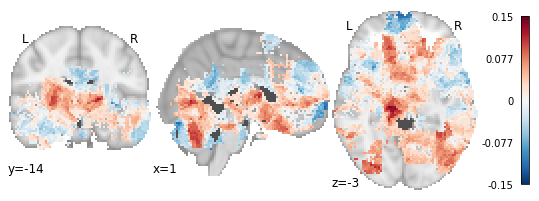

In [172]:
plot_stat_map(result2.get_map('z_desc-group1MinusGroup2'),
              draw_cross=False, cmap='RdBu_r')

In [68]:
# replace the nonzero voxels in brain mask with its corrected p value
corrected_p_mask = mask_array.copy()
np.place(corrected_p_mask, corrected_p_mask==1.0, corrected_p_value)

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [18]:
corrector = nimare.correct.FWECorrector(method='bonferroni', voxel_thresh=0.001, n_iters=10000, n_cores=-1)
corrected_result = corrector.transform(result)

In [19]:
corrected_p_value = corrected_result.get_map(name='p', return_type='array')

In [69]:
fail_to_reject = (corrected_p_value > 0.05).sum()
reject = ((corrected_p_value <= 0.05) & (corrected_p_value>0.01)).sum() #reject
print(fail_to_reject,reject)

213102 10173


In [21]:
349459+2868

352327

In [22]:

emotion_ale = nimare.meta.cbma.ALE()
emotion_ale_fit = emotion_ale.fit(emotion_dset)

emotion_ale_array = emotion_ale_fit.get_map(name='ale', return_type='array')
emotion_ale_map = emotion_ale_fit.get_map(name='ale', return_type='map')

In [23]:

happy_ale = nimare.meta.cbma.ALE()
happy_ale_fit = happy_ale.fit(happy_dset)

happy_ale_array = happy_ale_fit.get_map(name='ale', return_type='array')
happy_ale_map = happy_ale_fit.get_map(name='ale', return_type='map')

In [24]:
sad_ale = nimare.meta.cbma.ALE()
sad_ale_fit = sad_ale.fit(happy_dset)

sad_ale_array = sad_ale_fit.get_map(name='ale', return_type='array')
sad_ale_map = sad_ale_fit.get_map(name='ale', return_type='map')

In [25]:
# ale difference between happy/sad
ale_diff = nimare.meta.cbma.ALESubtraction()
ale_diff_fit = ale_diff.fit(happy_ale, sad_ale)



In [26]:
ale_diff_fit.maps

{'z_desc-group1MinusGroup2': array([0., 0., 0., ..., 0., 0., 0.])}

In [27]:
#ale_diff_array = ale_diff_fit.get_map(name='ale', return_type='array')
ale_diff_map = ale_diff_fit.get_map(name='z_desc-group1MinusGroup2', return_type='map')

In [28]:
ale_diff_map.shape

(228453,)

In [29]:
228453

228453

300876.3333333333